In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd

# Beam Experiment.

In [2]:
# load in soft labels.
beam_search_2_2_40 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/softlabels_2_2_40_beam_search_2_2_40.csv")
beam_search_2_4_40 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/softlabels_2_4_40_beam_search_2_4_40.csv")
beam_search_4_2_40 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/softlabels_4_2_40_beam_search_4_2_40.csv")
beam_search_4_4_40 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/softlabels_4_4_40_Numina_beam_search_4_4_40_fifth_chunk.csv")
beam_search_8_2_40 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/softlabels_8_2_40_beam_search_8_2_40.csv")
beam_search_8_4_20 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/softlabels_8_4_20_beam_search_8_4_20.csv")
beam_search_8_4_40 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/softlabels_beam_df_beam_search_8_4_40_chunk_28000_29000-beam_search_8_4_40_chunk_29000_30000.csv")
beam_search_16_2_40 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/softlabels_16_2_40_beam_search_16_2_40.csv")
beam_search_16_4_20 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/softlabels_16_4_20_beam_search_16_4_20.csv")
beam_search_16_4_40 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/softlabels_16_4_40_beam_search_16_4_40.csv")
beam_search_32_2_20 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/softlabels_32_2_20_beam_search_32_2_20.csv")
beam_search_32_4_40 = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/softlabels_32_4_40_beam_search_32_4_40.csv")

#### Get Latencies and Token-Counts

In [3]:
import re
import pandas as pd
import os
import glob

def parse_beam_data_from_filename(file_path):
    # Extract beam size and question range from filename
    # Example: "Beam-8-5010-5020.out" -> beam_size=8, start=5010, end=5020
    
    with open(file_path, 'r') as f:
        content = f.read()
    
    # Split content into question blocks
    blocks = re.split(r'Total beam search time: \d+\.\d+ seconds\.', content)
    blocks = [block.strip() for block in blocks if block.strip()]
    
    data = []
    prev_total_tokens = 0
    
    for i, block in enumerate(blocks):
        # Extract the last "Total number of tokens generated thus far: X" before the beam search time
        token_matches = re.findall(r'Total number of tokens generated thus far: (\d+)', block)
        
        if token_matches:
            current_total_tokens = int(token_matches[-1])
            
            # Calculate tokens for this question (difference from previous)
            beam_tc = current_total_tokens - prev_total_tokens
            
            # Extract beam latency from the next block's start
            if i < len(blocks) - 1:
                block_start = content.find(block)
                block_end = block_start + len(block)
                
                time_match = re.search(r'Total beam search time: (\d+\.\d+) seconds\.', content[block_end:])
                if time_match:
                    beam_latency = float(time_match.group(1))
                else:
                    beam_latency = None
            else:
                # For the last block, look at the end of the file
                time_match = re.search(r'Total beam search time: (\d+\.\d+) seconds\.$', content)
                beam_latency = float(time_match.group(1)) if time_match else None
            
            data.append({
                'beam_tc': beam_tc,
                'beam_latency': beam_latency
            })
            prev_total_tokens = current_total_tokens
    
    return pd.DataFrame(data)

In [ ]:
pita2240 = parse_beam_data_from_filename('/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/pita2240.out')
pita4240 = parse_beam_data_from_filename('/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/pita4240.out')
pita4420 = parse_beam_data_from_filename('/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/pita4420.out')
pita8420 = parse_beam_data_from_filename('/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/pita8420.out')
pita16240 = parse_beam_data_from_filename('/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/pita16240.out')
pita16420 = parse_beam_data_from_filename('/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/pita16420.out')
pita32220 = parse_beam_data_from_filename('/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/pita32220.out')
pita32240 = parse_beam_data_from_filename('/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/pita32240.out')


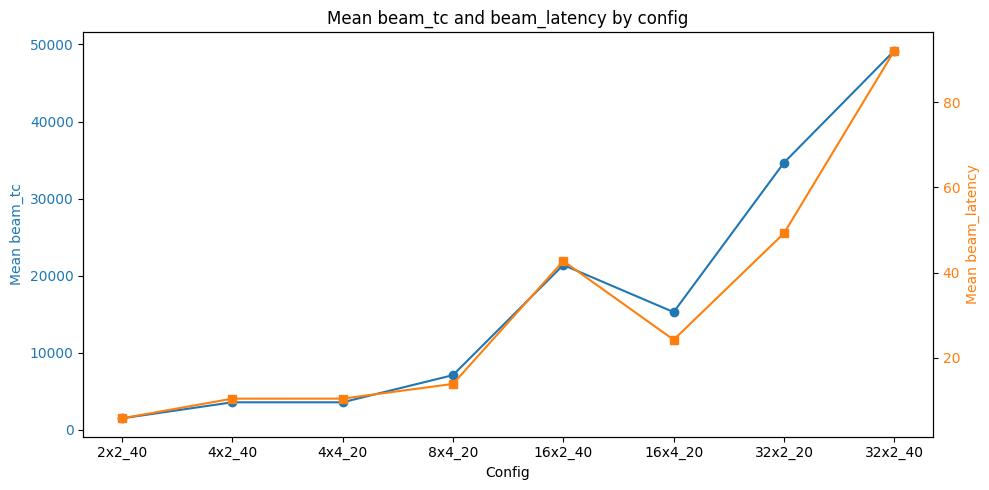

In [7]:
import matplotlib.pyplot as plt

names = [
    "2x2_40", "4x2_40", "4x4_20", "8x4_20",
    "16x2_40", "16x4_20", "32x2_20", "32x2_40"
]
dfs = [
    pita2240, pita4240, pita4420, pita8420,
    pita16240, pita16420, pita32220, pita32240
]

mean_beam_tc = [df['beam_tc'].mean() for df in dfs]
mean_beam_latency = [df['beam_latency'].mean() for df in dfs]

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Config')
ax1.set_ylabel('Mean beam_tc', color='tab:blue')
ax1.plot(names, mean_beam_tc, marker='o', color='tab:blue', label='Mean beam_tc')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Mean beam_latency', color='tab:orange')
ax2.plot(names, mean_beam_latency, marker='s', color='tab:orange', label='Mean beam_latency')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Mean beam_tc and beam_latency by config')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
total_2240 = pd.concat([beam_search_2_2_40, pita2240], axis=1)
total_4240 = pd.concat([beam_search_4_2_40, pita4240], axis=1)
total_4420 = pd.concat([beam_search_4_4_40, pita4420], axis=1)
total_8420 = pd.concat([beam_search_8_4_20, pita8420], axis=1)
total_16240 = pd.concat([beam_search_16_2_40, pita16240], axis=1)
total_16420 = pd.concat([beam_search_16_4_20, pita16420], axis=1)
total_32220 = pd.concat([beam_search_32_2_20, pita32220], axis=1)
total_32240 = pd.concat([beam_search_32_4_40, pita32240], axis=1) # slight mismatch in beam width with this config.

all_beam_numina = pd.concat(
    [total_2240, total_4240, total_4420, total_8420, total_16240, total_16420, total_32220, total_32240],
    axis=0
)

all_beam_numina_df = pd.DataFrame(all_beam_numina)
# all_beam_numina_df.to_csv('/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/all_beam_numina.csv', index=False)

In [9]:
all_beam_numina_df = all_beam_numina_df.rename(columns={'chunk_size': 'max_iteration'})
all_beam_numina_df.head(), all_beam_numina_df.shape

(                                             problem       method    N  \
 0  Consider the terms of an arithmetic sequence: ...  beam_search  2.0   
 1  Suppose that $g(x) = 5x - 3$. What is $g^{-1}(...  beam_search  2.0   
 2  A farmer has a rectangular field with dimensio...  beam_search  2.0   
 3  Given the functions $f(x) = \log_a(1+x)$ and $...  beam_search  2.0   
 4  Find all solutions to the equation $\displayst...  beam_search  2.0   
 
    beam_width  max_iteration        sl  beam_tc  beam_latency  
 0         2.0           40.0  1.000000      838          5.84  
 1         2.0           40.0  1.000000      945          3.59  
 2         2.0           40.0  0.566667     2999         13.43  
 3         2.0           40.0  0.400000     2181          8.38  
 4         2.0           40.0  0.000000     1989          8.75  ,
 (40000, 8))

In [10]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
import data_processing.create_question_id

# Fit on filtered_df and save
q_to_id = data_processing.create_question_id.build_q_to_id(all_beam_numina_df, question_col="problem", start=0)
data_processing.create_question_id.save_mapping(q_to_id, "q_to_id_beam_numina.json")

# Load and apply to filtered_df
q_to_id = data_processing.create_question_id.load_mapping("q_to_id_beam_numina.json")
all_beam_numina_df_w_sb_idx = data_processing.create_question_id.apply_q_to_id(all_beam_numina_df, q_to_id, question_col="problem")
all_beam_numina_df_w_sb_idx.head()

,problem,method,N,beam_width,max_iteration,sl,beam_tc,beam_latency,sb_idx
0,Consider the terms of an arithmetic sequence: ...,beam_search,2.0,2.0,40.0,1.000000,838,5.84,1882
1,Suppose that $g(x) = 5x - 3$. What is $g^{-1}(...,beam_search,2.0,2.0,40.0,1.000000,945,3.59,8045
2,A farmer has a rectangular field with dimensio...,beam_search,2.0,2.0,40.0,0.566667,2999,13.43,495
3,Given the functions $f(x) = \log_a(1+x)$ and $...,beam_search,2.0,2.0,40.0,0.400000,2181,8.38,4300
4,Find all solutions to the equation $\displayst...,beam_search,2.0,2.0,40.0,0.000000,1989,8.75,2448


In [ ]:
# create train/val/test split based on 'sb_idx' (query identifier)
from sklearn.model_selection import train_test_split

unique_sb_idx = all_beam_numina_df_w_sb_idx['sb_idx'].unique()

# Split into train and test only
sb_idx_train, sb_idx_test = train_test_split(
    unique_sb_idx,
    test_size=0.15,
    random_state=2
)

# Divide queries (represented by sb_idx) into train and test
df_train_beam_numina = all_beam_numina_df_w_sb_idx[all_beam_numina_df_w_sb_idx['sb_idx'].isin(sb_idx_train)].reset_index(drop=True)
df_test_beam_numina = all_beam_numina_df_w_sb_idx[all_beam_numina_df_w_sb_idx['sb_idx'].isin(sb_idx_test)].reset_index(drop=True)

# df_train_beam_numina.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/df_train_beam_numina.csv", index=False)
# df_test_beam_numina.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/df_test_beam_numina.csv", index=False)


In [ ]:
import pandas as pd

df_train_beam_numina = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/df_train_beam_numina.csv")
df_test_beam_numina = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/df_test_beam_numina.csv")

In [3]:
df_train_beam_numina.shape, df_test_beam_numina.shape
df_train_beam_numina["problem"].nunique(), df_test_beam_numina["problem"].nunique()

(8488, 1498)

Router for Beam Search.

In [ ]:
softLabels = np.load('/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/softLabel_preds.npy') # fine-tuned bert...not doing so well.
softLabels.shape

(6010,)

In [6]:
df_test_beam_numina['predicted_prob'] = softLabels

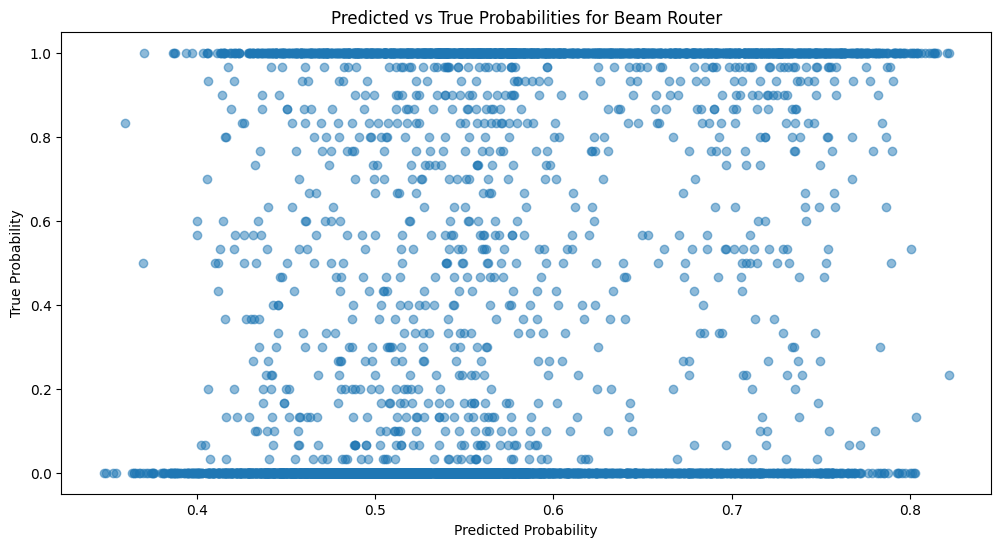

In [7]:
# plot predicted probabilities vs true probabilities.
# bert fine tuned. pca=32.
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(softLabels, df_test_beam_numina['sl'], alpha=0.5)
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Predicted vs True Probabilities for Beam Router")
plt.show()

bin
(0.333, 0.367]       9
(0.367, 0.4]        60
(0.4, 0.433]       235
(0.433, 0.467]     543
(0.467, 0.5]       856
(0.5, 0.533]       910
(0.533, 0.567]    1007
(0.567, 0.6]       704
(0.6, 0.633]       330
(0.633, 0.667]     267
(0.667, 0.7]       327
(0.7, 0.733]       359
(0.733, 0.767]     270
(0.767, 0.8]       108
(0.8, 0.833]        25
Name: count, dtype: int64


/tmp/ipykernel_3733112/3735892860.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_test_beam_numina.groupby("bin").agg(


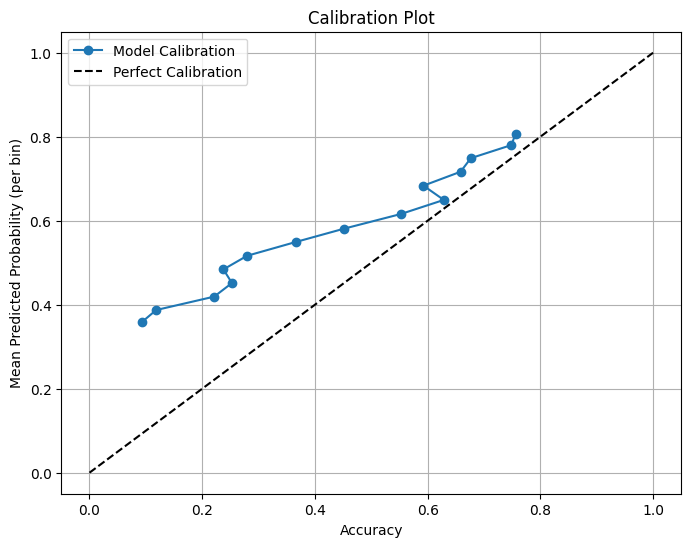

In [8]:
# plot a calibration plot.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define bin edges and assign each predicted_prob to a bin
num_bins = 30
df_test_beam_numina["bin"] = pd.cut(df_test_beam_numina["predicted_prob"], bins=np.linspace(0, 1, num_bins + 1), include_lowest=True)

# Group by bins and compute average predicted prob and accuracy
calibration = df_test_beam_numina.groupby("bin").agg(
    avg_pred_prob=("predicted_prob", "mean"),
    accuracy=("sl", "mean"),
    count=("sl", "count")
).dropna()

# Print the number of points in each bin
print(calibration["count"])

# Plot calibration curve with flipped axes
plt.figure(figsize=(8, 6))
plt.plot(calibration["accuracy"], calibration["avg_pred_prob"], marker='o', label="Model Calibration")
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Accuracy")
plt.ylabel("Mean Predicted Probability (per bin)")
plt.title("Calibration Plot")
plt.grid(True)
plt.legend()
plt.show()

Train using Best Probe (seen so far)

In [4]:
# features created using extract_features_simple.py
# load in train data.
X_train = np.load('/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/X_train.npy')
y_train = np.load('/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/y_train.npy')

# load in test data.
X_test = np.load('/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/X_test.npy')
y_test = np.load('/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/y_test.npy')

In [32]:
# split high-dimensional CLS and interpretable features
cls_dim = 1536 # 768 # len(cls_vec)
cls_part = X_train[:, :cls_dim]
named_features = pd.DataFrame(
    X_train[:, cls_dim:],  # shape (n_samples, 5)
    columns=["N", "beam_width", "max_iteration", "problem_length"] # , "method_weighted"
)

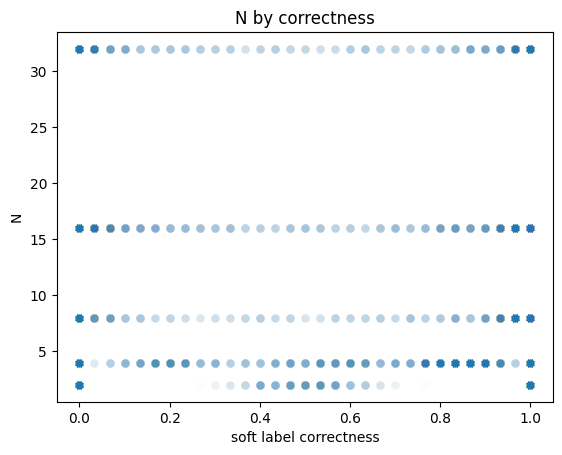

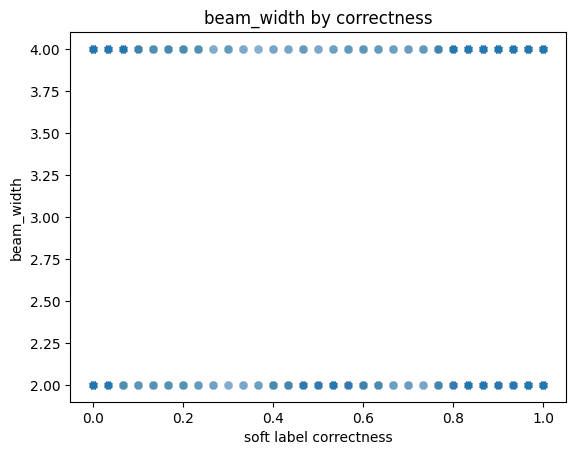

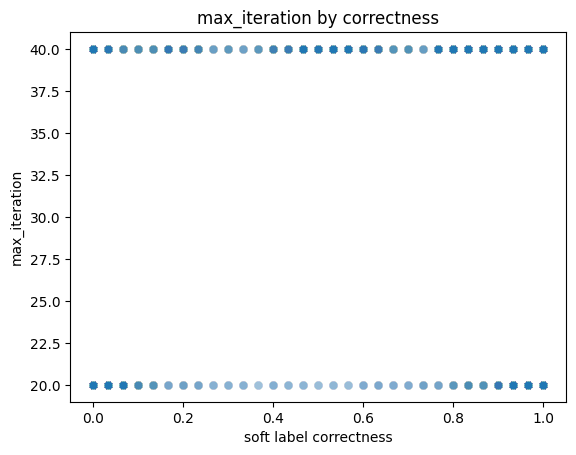

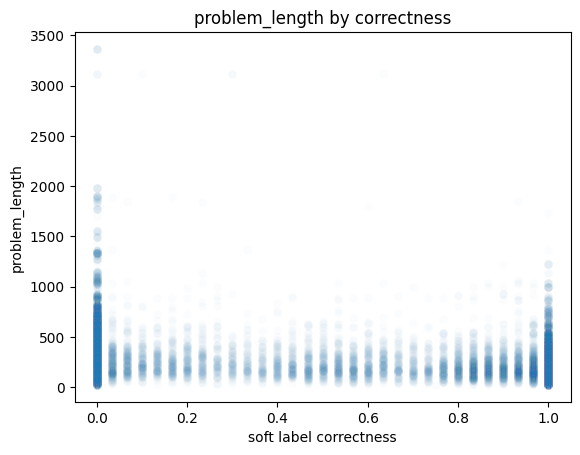

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in named_features.columns:
    sns.scatterplot(x=y_train, y=named_features[col], alpha=0.02)
    plt.title(f"{col} by correctness")
    plt.xlabel("soft label correctness")
    plt.ylabel(col)
    plt.show()

there seem to be very little signal in these beam-related numerical features.

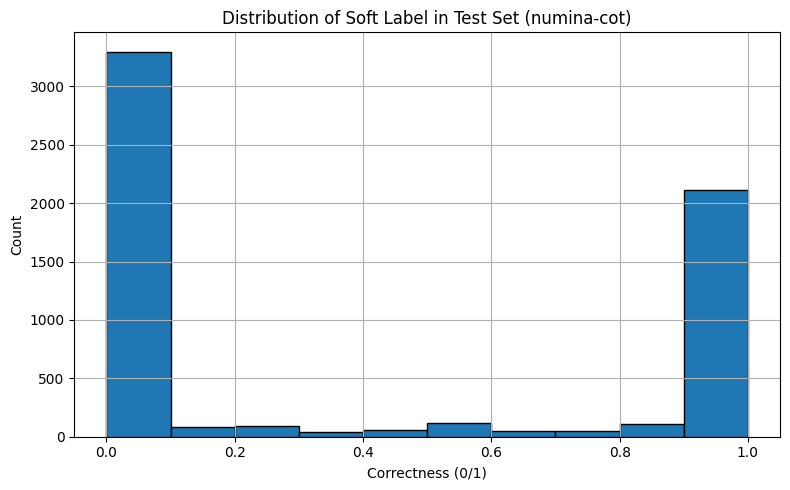

In [36]:
# histogram of y_test.
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(y_test, bins=10, edgecolor='black')
plt.xlabel("Correctness (0/1)")
plt.ylabel("Count")
plt.title("Distribution of Soft Label in Test Set (numina-cot)")
plt.grid(True)
plt.tight_layout()

In [6]:
### Train MLP.
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((33969, 1540), (33969,), (6010, 1540), (6010,))

#### Create Custom MLP (soft labels)

In [10]:
import torch
import torch.nn as nn                        # for neural network layers, loss functions, etc.
from torch.utils.data import Dataset, DataLoader, random_split      # for batching and shuffling datasets
import torch.optim as optim

In [11]:
# ----- 2. Dataset Definition -----
class SoftLabelDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ----- 3. Dataloaders -----
train_dataset = SoftLabelDataset(X_train, y_train)
val_dataset = SoftLabelDataset(X_test, y_test)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ----- 4. Calibration split -----
calib_frac = 0.2
calib_size = int(len(train_dataset) * calib_frac)
train_size = len(train_dataset) - calib_size

train_dataset, calib_dataset = random_split(train_dataset, [train_size, calib_size])


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
calib_loader = DataLoader(calib_dataset, batch_size=64, shuffle=False)


In [12]:
# ----- 4. MLP Model -----
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 200),  # First layer with 200 hidden units
            nn.GELU(),                 # GELU activation
            nn.Linear(200, 200),       # Second layer with 200 hidden units
            nn.GELU(),                 # GELU activation
            nn.Linear(200, 1)         # Output layer
            # nn.Sigmoid()               # Sigmoid for binary cross-entropy with soft targets
        )

    def forward(self, x):
        return self.model(x)

model = MLP(input_dim=1540)

# ----- 5. Loss and Optimizer -----
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for soft binary targets
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [13]:
# ----- 6. Training Loop -----
num_epochs = 100  # Maximum of 10,000 epochs
batch_size = 128    # Batch size of 128
patience = 10      # Early stopping patience

agg_train_loss = []
agg_val_loss = []
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = []
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # Validation
    model.eval()
    val_loss = []
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_preds = model(val_X)
            val_loss.append(criterion(val_preds, val_y).item())
    mean_train_loss = np.mean(train_loss)
    mean_val_loss = np.mean(val_loss)

    agg_train_loss.append(mean_train_loss)
    agg_val_loss.append(mean_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {mean_train_loss:.4f}, Val Loss: {mean_val_loss:.4f}")

    # Early stopping
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1, Train Loss: 0.5818, Val Loss: 0.5468
Epoch 2, Train Loss: 0.5355, Val Loss: 0.5347
Epoch 3, Train Loss: 0.5172, Val Loss: 0.5259
Epoch 4, Train Loss: 0.5046, Val Loss: 0.5195
Epoch 5, Train Loss: 0.4942, Val Loss: 0.5176
Epoch 6, Train Loss: 0.4853, Val Loss: 0.5139
Epoch 7, Train Loss: 0.4767, Val Loss: 0.5122
Epoch 8, Train Loss: 0.4690, Val Loss: 0.5192
Epoch 9, Train Loss: 0.4624, Val Loss: 0.5132
Epoch 10, Train Loss: 0.4550, Val Loss: 0.5208
Epoch 11, Train Loss: 0.4483, Val Loss: 0.5128
Epoch 12, Train Loss: 0.4411, Val Loss: 0.5213
Epoch 13, Train Loss: 0.4346, Val Loss: 0.5172
Epoch 14, Train Loss: 0.4274, Val Loss: 0.5201
Epoch 15, Train Loss: 0.4218, Val Loss: 0.5221
Epoch 16, Train Loss: 0.4152, Val Loss: 0.5232
Epoch 17, Train Loss: 0.4076, Val Loss: 0.5188
Early stopping at epoch 17


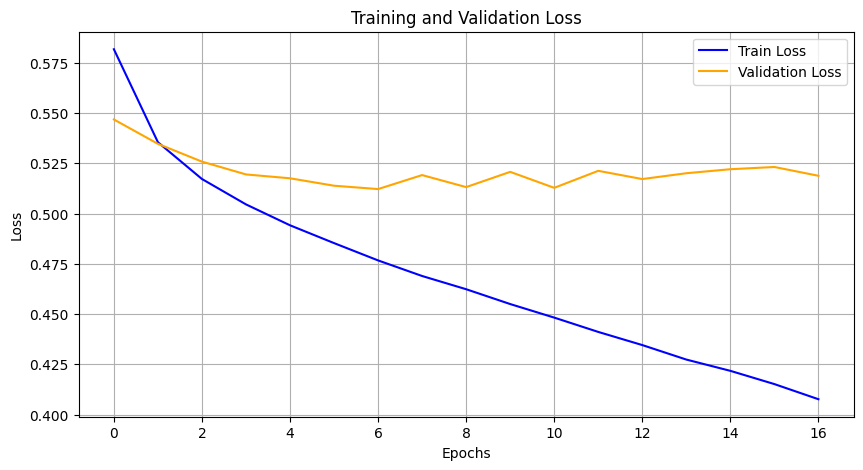

In [14]:
# ----- 7. Plot Training and Validation Loss -----
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(agg_train_loss, label='Train Loss', color='blue')
plt.plot(agg_val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

class PlattCalibrator(nn.Module):
    """p = sigmoid(a * logit + b)"""
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.ones(1))
        self.b = nn.Parameter(torch.zeros(1))
    def forward(self, logits):         # returns *logits* after affine map
        return self.a * logits + self.b
    def predict_proba(self, logits):   # returns calibrated probabilities
        return torch.sigmoid(self.forward(logits))

@torch.no_grad()
def collect_logits_and_labels(model, loader, device="cpu"):
    model.eval()
    all_logits, all_y = [], []
    for X, y in loader:
        X = X.to(device)
        logits = model(X)              # [B,1] logits
        all_logits.append(logits.squeeze(1).cpu())
        all_y.append(y.squeeze(1).cpu())  # y can be soft in [0,1]
    return torch.cat(all_logits), torch.cat(all_y)

# After training the base model:
device = next(model.parameters()).device
logits_cal, y_cal = collect_logits_and_labels(model, calib_loader, device)

calibrator = PlattCalibrator().to(device)
bce_logits = nn.BCEWithLogitsLoss()  # proper for soft labels too
opt = optim.LBFGS(calibrator.parameters(), lr=1.0, max_iter=100, line_search_fn="strong_wolfe")

def closure():
    opt.zero_grad()
    z = calibrator(logits_cal.to(device))  # affine logits
    loss = bce_logits(z, y_cal.to(device))
    loss.backward()
    return loss

opt.step(closure)

print(f"Platt params: a={calibrator.a.item():.4f}, b={calibrator.b.item():.4f}")


Platt params: a=1.1935, b=0.0743


In [ ]:
# use the calibrated predictor for inference.
@torch.no_grad()
def predict_calibrated_proba(model, calibrator, X, device="cpu"):
    model.eval()
    X = X.to(device)
    logits = model(X)
    return calibrator.predict_proba(logits).squeeze(1)

# Example on the test set:
probs = []
ys = []
with torch.no_grad():
    for X, y in val_loader:
        p = predict_calibrated_proba(model, calibrator, X, device)
        probs.append(p.cpu())
        ys.append(y.squeeze(1).cpu())
calibrated_probs = torch.cat(probs)
ys = torch.cat(ys)


In [21]:
print(calibrated_probs.shape, calibrated_probs.min().item(), calibrated_probs.max().item())
print(ys.shape, ys.min().item(), ys.max().item())

torch.Size([6010]) 0.0020557420793920755 0.9972129464149475
torch.Size([6010]) 0.0 1.0


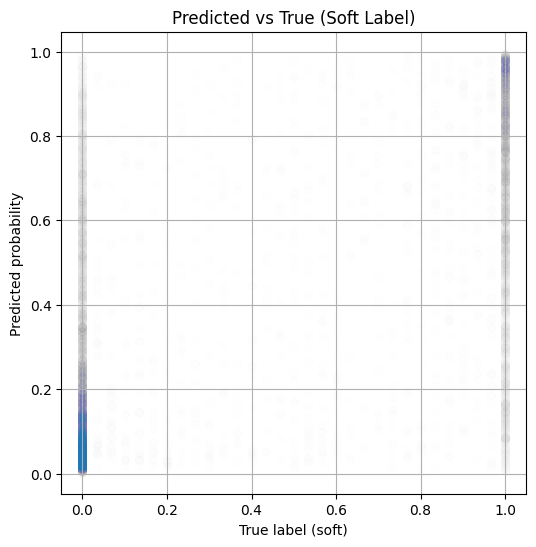

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(ys, calibrated_probs, alpha=0.005)
plt.xlabel("True label (soft)")
plt.ylabel("Predicted probability")
plt.title("Predicted vs True (Soft Label)")
plt.grid(True)
plt.show()

Plot a calibration chart.

In [ ]:
calibrated_probs = calibrated_probs.cpu().numpy()

In [26]:
df_test_beam_numina["calibrated_probs"] = calibrated_probs

bin
(-0.001, 0.0333]    454
(0.0333, 0.0667]    628
(0.0667, 0.1]       442
(0.1, 0.133]        326
(0.133, 0.167]      285
(0.167, 0.2]        233
(0.2, 0.233]        193
(0.233, 0.267]      179
(0.267, 0.3]        128
(0.3, 0.333]        142
(0.333, 0.367]      142
(0.367, 0.4]        117
(0.4, 0.433]        123
(0.433, 0.467]      109
(0.467, 0.5]        123
(0.5, 0.533]        134
(0.533, 0.567]      145
(0.567, 0.6]        126
(0.6, 0.633]        151
(0.633, 0.667]      150
(0.667, 0.7]        142
(0.7, 0.733]        162
(0.733, 0.767]      157
(0.767, 0.8]        157
(0.8, 0.833]        177
(0.833, 0.867]      173
(0.867, 0.9]        170
(0.9, 0.933]        182
(0.933, 0.967]      205
(0.967, 1.0]        155
Name: count, dtype: int64


/tmp/ipykernel_3780516/1952915704.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_test_beam_numina.groupby("bin").agg(


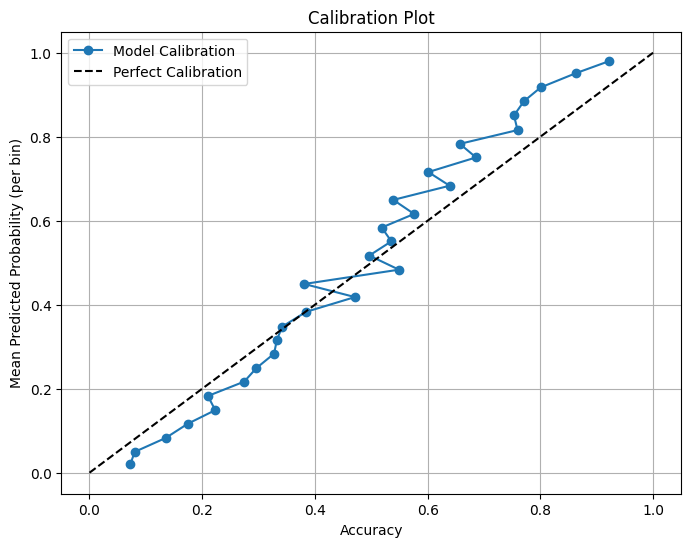

In [27]:
# plot a calibration plot.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define bin edges and assign each predicted_prob to a bin
num_bins = 30
df_test_beam_numina["bin"] = pd.cut(calibrated_probs, bins=np.linspace(0, 1, num_bins + 1), include_lowest=True)

# Group by bins and compute average predicted prob and accuracy
calibration = df_test_beam_numina.groupby("bin").agg(
    avg_pred_prob=("calibrated_probs", "mean"),
    accuracy=("sl", "mean"),
    count=("sl", "count")
).dropna()

# Print the number of points in each bin
print(calibration["count"])

# Plot calibration curve with flipped axes
plt.figure(figsize=(8, 6))
plt.plot(calibration["accuracy"], calibration["avg_pred_prob"], marker='o', label="Model Calibration")
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Accuracy")
plt.ylabel("Mean Predicted Probability (per bin)")
plt.title("Calibration Plot")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#### Uncalibrated Probs.

In [176]:
#### Make Predictions on Test (soft label response).
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

with torch.no_grad():
    softLabel_Preds = model(X_test_tensor)
softLabel_preds_numpy = softLabel_Preds.squeeze().cpu().numpy()
softLabel_preds_numpy

array([0.1051059 , 0.22276817, 0.5059284 , ..., 0.90265435, 0.30327561,
       0.9559052 ], dtype=float32)

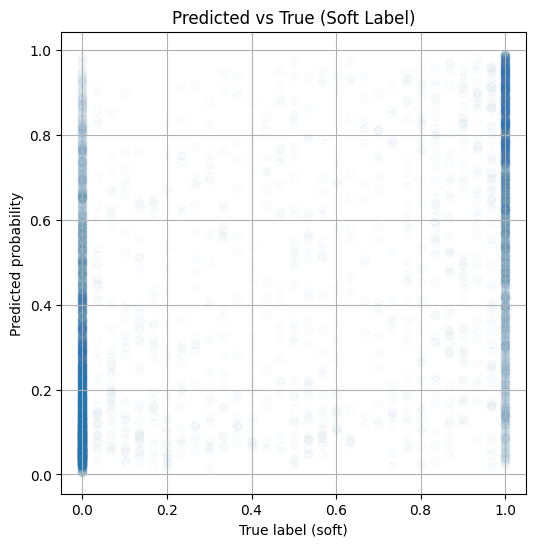

In [178]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, softLabel_preds_numpy, alpha=0.016)
plt.xlabel("True label (soft)")
plt.ylabel("Predicted probability")
plt.title("Predicted vs True (Soft Label)")
plt.grid(True)
plt.show()


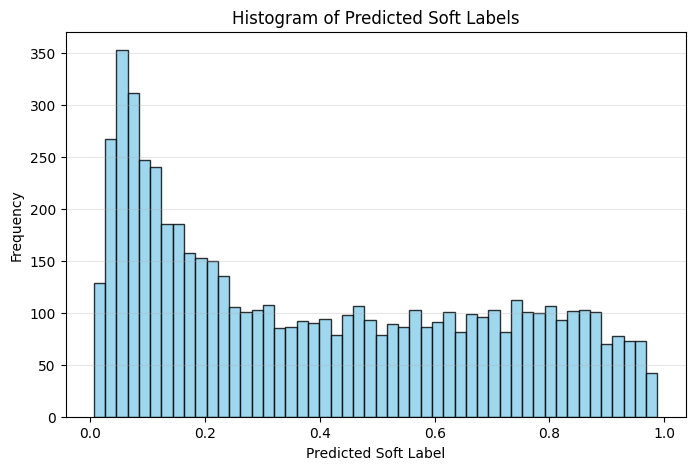

In [50]:
plt.figure(figsize=(8, 5))
plt.hist(softLabel_preds_numpy, bins=50, color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel("Predicted Soft Label")
plt.ylabel("Frequency")
plt.title("Histogram of Predicted Soft Labels")
plt.grid(True, axis='y', alpha=0.3)
plt.show()


In [ ]:
df_test_beam_numina['predicted_prob'] = softLabel_preds_numpy

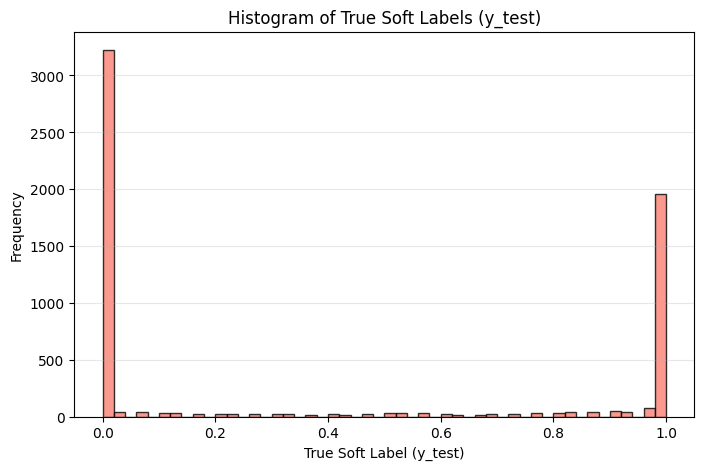

In [87]:
plt.figure(figsize=(8, 5))
plt.hist(df_test_beam_numina['sl'], bins=50, color='salmon', edgecolor='black', alpha=0.8)
plt.xlabel("True Soft Label (y_test)")
plt.ylabel("Frequency")
plt.title("Histogram of True Soft Labels (y_test)")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

Join Beam with BoN/MV (and additional beam data from the numina-cot-16000 experiment).

In [151]:
df_train_downsamp6 = pd.read_csv('/dccstor/gma2/jhjenny9/search-and-learn/data/df_train_downsamp6.csv')
df_test_downsamp6 = pd.read_csv('/dccstor/gma2/jhjenny9/search-and-learn/data/df_test_downsamp6.csv')

df_train_downsamp6.shape, df_test_downsamp6.shape

((92058, 10), (10230, 10))

In [152]:
df_train_beam_numina.shape, df_test_beam_numina.shape

((33969, 13), (6010, 15))

In [154]:
df_test_beam_numina.head()

,problem,method,N,beam_width,max_iteration,sl,beam_tc,beam_latency,sb_idx,bin,calibrated_probs,method_beam_search,method_maj,method_naive,method_weighted
0,Given the functions $f(x) = \log_a(1+x)$ and $...,beam_search,2.0,2.0,40.0,0.4,2181,8.38,4300,"(0.0333, 0.0667]",0.051458,1,0,0,0
1,Given that the sum of the first $n$ terms of a...,beam_search,2.0,2.0,40.0,0.0,1834,5.00,3949,"(0.333, 0.367]",0.355935,1,0,0,0
2,How many two-digit positive integers are congr...,beam_search,2.0,2.0,40.0,0.0,649,2.93,4759,"(0.567, 0.6]",0.569496,1,0,0,0
3,The molecular weight of a certain substance is...,beam_search,2.0,2.0,40.0,0.0,800,3.45,8591,"(0.0667, 0.1]",0.084768,1,0,0,0
4,"Given that \(1 \leq x, y, z \leq 6\), how many...",beam_search,2.0,2.0,40.0,0.0,805,2.70,3763,"(0.0333, 0.0667]",0.060933,1,0,0,0


2/3 of the data will come from the downsample-6 experiment, 1/3 will come from the new beam experiment.

In [150]:
df_train_beam_numina['method_beam_search'] = 1
df_train_beam_numina['method_maj'] = 0
df_train_beam_numina['method_naive'] = 0
df_train_beam_numina['method_weighted'] = 0

df_test_beam_numina['method_beam_search'] = 1
df_test_beam_numina['method_maj'] = 0
df_test_beam_numina['method_naive'] = 0
df_test_beam_numina['method_weighted'] = 0


In [155]:
df_train_downsamp6['beam_width'] = np.where(df_train_downsamp6['method_beam_search'] == 1, 4, 0)
df_train_downsamp6['max_iteration'] = np.where(df_train_downsamp6['method_beam_search'] == 1, 40, 0)
df_test_downsamp6['beam_width'] = np.where(df_test_downsamp6['method_beam_search'] == 1, 4, 0)
df_test_downsamp6['max_iteration'] = np.where(df_test_downsamp6['method_beam_search'] == 1, 40, 0)
df_train_downsamp6.head()

,question,N,sl,question_length,method_beam_search,method_maj,method_naive,method_weighted,method,sb_idx,beam_width,max_iteration
0,"""$a \neq 2$"" is the condition for ""line $l_1: ...",16,0.566667,267,False,True,False,False,majority,0,0,0
1,"""$a \neq 2$"" is the condition for ""line $l_1: ...",16,0.866667,267,False,False,True,False,naive,0,0,0
2,"""$a \neq 2$"" is the condition for ""line $l_1: ...",4,0.633333,267,False,False,True,False,naive,0,0,0
3,"""$a \neq 2$"" is the condition for ""line $l_1: ...",4,0.433333,267,False,True,False,False,majority,0,0,0
4,"""$a \neq 2$"" is the condition for ""line $l_1: ...",2,0.533333,267,False,False,False,True,weighted,0,0,0


In [158]:
df_test_beam_numina.head()

,problem,method,N,beam_width,max_iteration,sl,beam_tc,beam_latency,sb_idx,bin,calibrated_probs,method_beam_search,method_maj,method_naive,method_weighted
0,Given the functions $f(x) = \log_a(1+x)$ and $...,beam_search,2.0,2.0,40.0,0.4,2181,8.38,4300,"(0.0333, 0.0667]",0.051458,1,0,0,0
1,Given that the sum of the first $n$ terms of a...,beam_search,2.0,2.0,40.0,0.0,1834,5.00,3949,"(0.333, 0.367]",0.355935,1,0,0,0
2,How many two-digit positive integers are congr...,beam_search,2.0,2.0,40.0,0.0,649,2.93,4759,"(0.567, 0.6]",0.569496,1,0,0,0
3,The molecular weight of a certain substance is...,beam_search,2.0,2.0,40.0,0.0,800,3.45,8591,"(0.0667, 0.1]",0.084768,1,0,0,0
4,"Given that \(1 \leq x, y, z \leq 6\), how many...",beam_search,2.0,2.0,40.0,0.0,805,2.70,3763,"(0.0333, 0.0667]",0.060933,1,0,0,0


- combine df_train for beam_numina and downsamp6.

- combine df_test for beam_numina and downsamp6.

- create feature embeddings using extract features simple.

- train model (optional: calibrate model).

- format test_set for beam_numina and downsamp6 (aka, add tc + latency or beam_tc + beam_latency).

In [147]:
df_train_downsamp6['N'].value_counts()

N
4     30587
16    26442
8     22321
2     12708
Name: count, dtype: int64

In [ ]:
# created using concatenate_completions.py.
# bon_token_counts = pd.read_csv('/dccstor/gma2/jhjenny9/search-and-learn/training-res/numinaMath/bon_token_counts_16000.csv')
# bon_token_counts = bon_token_counts.rename(columns={"problem": "question"})
# bon_token_counts.head()
# df_test = df_test.merge(bon_token_counts, on="question", how="left") # change df_test to have appropriate columns (beam_width, max_iteration, etc.)
# df_test.head()

Input: A dataframe that contains rows for different settings (beam size, beam width, chunk size, etc.) and includes: an accuracy column, an avg_cot_token_count column (which is the cost), and a sb_idx column (which is the query).

A parameter, lambda, that controls how much the user is willing to tradeoff accuracy and cost.

For each group (i.e., all rows of the same query, or sb_idx):

It computes a utility value for each row:

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

It finds the row with the highest utility in that group.

Output:
A new DataFrame where each row corresponds to a query and contains:
the best utility found, the accuracy, and cost for that best-performing configuration.


In [28]:
df_test_beam_numina.head()

,problem,method,N,beam_width,max_iteration,sl,beam_tc,beam_latency,sb_idx,bin,calibrated_probs
0,Given the functions $f(x) = \log_a(1+x)$ and $...,beam_search,2.0,2.0,40.0,0.4,2181,8.38,4300,"(0.0333, 0.0667]",0.051458
1,Given that the sum of the first $n$ terms of a...,beam_search,2.0,2.0,40.0,0.0,1834,5.00,3949,"(0.333, 0.367]",0.355935
2,How many two-digit positive integers are congr...,beam_search,2.0,2.0,40.0,0.0,649,2.93,4759,"(0.567, 0.6]",0.569496
3,The molecular weight of a certain substance is...,beam_search,2.0,2.0,40.0,0.0,800,3.45,8591,"(0.0667, 0.1]",0.084768
4,"Given that \(1 \leq x, y, z \leq 6\), how many...",beam_search,2.0,2.0,40.0,0.0,805,2.70,3763,"(0.0333, 0.0667]",0.060933


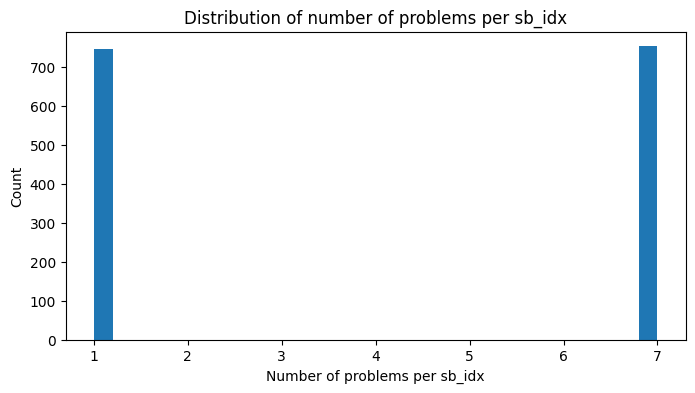

In [29]:
import matplotlib.pyplot as plt

sb_idx_counts = df_test_beam_numina.groupby("sb_idx").size()
plt.figure(figsize=(8,4))
plt.hist(sb_idx_counts, bins=30)
plt.xlabel("Number of problems per sb_idx")
plt.ylabel("Count")
plt.title("Distribution of number of problems per sb_idx")
plt.show()

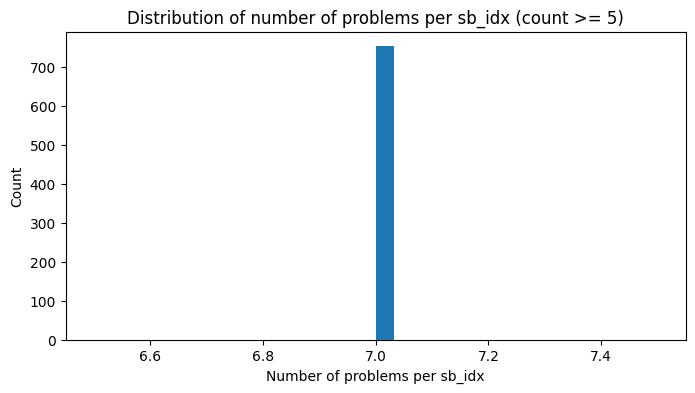

In [30]:
sb_idx_counts = df_test_beam_numina.groupby("sb_idx").size()
filtered_counts = sb_idx_counts[sb_idx_counts > 1]
plt.figure(figsize=(8,4))
plt.hist(filtered_counts, bins=30)
plt.xlabel("Number of problems per sb_idx")
plt.ylabel("Count")
plt.title("Distribution of number of problems per sb_idx (count >= 5)")
plt.show()

In [31]:
# keep only sb_idx with at least 2 beam configs to choose between for routing.
# this is because there exists a certain subset of problems that have only 1 beam config, so routing is not possible.
df_beam_filtered = df_test_beam_numina[df_test_beam_numina["sb_idx"].isin(filtered_counts.index)]

In [32]:
df_beam_filtered.head(), df_beam_filtered.shape

(                                             problem       method    N  \
 0  Given the functions $f(x) = \log_a(1+x)$ and $...  beam_search  2.0   
 1  Given that the sum of the first $n$ terms of a...  beam_search  2.0   
 2  How many two-digit positive integers are congr...  beam_search  2.0   
 3  The molecular weight of a certain substance is...  beam_search  2.0   
 4  Given that \(1 \leq x, y, z \leq 6\), how many...  beam_search  2.0   
 
    beam_width  max_iteration   sl  beam_tc  beam_latency  sb_idx  \
 0         2.0           40.0  0.4     2181          8.38    4300   
 1         2.0           40.0  0.0     1834          5.00    3949   
 2         2.0           40.0  0.0      649          2.93    4759   
 3         2.0           40.0  0.0      800          3.45    8591   
 4         2.0           40.0  0.0      805          2.70    3763   
 
                 bin  calibrated_probs  
 0  (0.0333, 0.0667]          0.051458  
 1    (0.333, 0.367]          0.355935  
 2      (

In [34]:
# get the average accuracy and token_count for each configuration of step-beam that was run.
config_summary_df = df_beam_filtered.groupby(["N", "beam_width", "max_iteration"])[
    ["sl", "calibrated_probs", "beam_tc", "beam_latency"] # accuracy keeps track of Pass@N (aka, percentage of correct answers).
].mean().reset_index()

# rename beam_tc to token_count and beam_latency to time.
config_summary_df = config_summary_df.rename(columns={"beam_tc" : "token_count", "beam_latency" : "time"})
config_summary_df.head()

,N,beam_width,max_iteration,sl,calibrated_probs,token_count,time
0,2.0,2.0,40.0,0.330541,0.347726,1419.746011,5.567779
1,4.0,2.0,40.0,0.352615,0.356148,3352.678191,9.737513
2,8.0,4.0,20.0,0.404255,0.402228,6967.848404,13.537566
3,16.0,2.0,40.0,0.422296,0.406630,20778.591755,41.705040
4,16.0,4.0,20.0,0.433910,0.435207,15182.727394,24.105718


In [41]:
def compute_max_utility_pred(df, lambda_, method="oracle", cost="beam_tc"):
    def get_max_utility(group): # verified correctness.
        group = group.copy()
        if method == "oracle":
            group["utility"] = group["sl"] - lambda_ * group[cost]
        elif method == "adaptive_router":
            group["utility"] = group["calibrated_probs"] - lambda_ * group[cost]
        else:
            raise ValueError(f"Invalid method: {method}")
        idx_max = group["utility"].idxmax()

        return pd.Series({
            "max_utility": group.loc[idx_max, "utility"],
            "max_predicted_prob": group.loc[idx_max, "calibrated_probs"],
            "max_sl": group.loc[idx_max, "sl"], # indicator that keeps track of whether the answer is correct.
            "max_cost": group.loc[idx_max, "beam_tc"],
            "max_time": group.loc[idx_max, "beam_latency"],
            "N": group.loc[idx_max, "N"],
            "beam_width": group.loc[idx_max, "beam_width"],
            "max_iteration": group.loc[idx_max, "max_iteration"]
        })

    result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
    return result_df

In [42]:
def get_router_df(input_df, lambda_list, method="oracle", cost="beam_tc"):
    results = []

    for lambda_value in lambda_list:
        adaptive_router = compute_max_utility_pred(input_df, lambda_value, method, cost)
        average_accuracy = adaptive_router["max_sl"].mean() # accuracy as a percentage of questions (out of all questions in the test set) answered correctly.
        average_cost = adaptive_router["max_cost"].mean()
        average_time = adaptive_router["max_time"].mean()
        average_predicted_prob = adaptive_router["max_predicted_prob"].mean()
        
        results.append({
            "lambda": lambda_value,
            "sl": average_accuracy,
            "token_count": average_cost,
            "predicted_prob": average_predicted_prob,
            "time": average_time,
        })

    # Convert to DataFrame
    output_df = pd.DataFrame(results)
    output_df["method"] = method

    return output_df


In [130]:
adaptive_tc = get_router_df(df_beam_filtered, lambda_list=np.logspace(-7, -1, num=100), method="adaptive_router", cost="beam_tc")
oracle_tc = get_router_df(df_beam_filtered, lambda_list=np.logspace(-7, -1, num=100), method="oracle", cost="beam_tc")

adaptive_lat = get_router_df(df_beam_filtered, lambda_list=np.logspace(-5, -1, num=100), method="adaptive_router", cost="beam_latency")
oracle_lat = get_router_df(df_beam_filtered, lambda_list=np.logspace(-5, -1, num=100), method="oracle", cost="beam_latency")

/tmp/ipykernel_3780516/1344974592.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_3780516/1344974592.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_3780516/1344974592.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping co

In [131]:
adaptive_tc.head(45)

,lambda,sl,token_count,predicted_prob,time,method
0,1.000000e-07,0.451995,34363.857713,0.494898,51.289934,adaptive_router
1,1.149757e-07,0.451995,34235.494681,0.494884,50.969774,adaptive_router
2,1.321941e-07,0.451995,34143.038564,0.494872,50.796370,adaptive_router
3,1.519911e-07,0.452305,33742.345745,0.494815,50.357886,adaptive_router
4,1.747528e-07,0.451064,33595.517287,0.494791,50.144402,adaptive_router
5,2.009233e-07,0.451064,33393.187500,0.494753,49.746090,adaptive_router
6,2.310130e-07,0.450754,32980.400266,0.494663,49.240359,adaptive_router
7,2.656088e-07,0.450931,32798.011968,0.494619,49.033338,adaptive_router
8,3.053856e-07,0.450931,32329.182181,0.494485,48.348976,adaptive_router
9,3.511192e-07,0.450621,32117.461436,0.494418,48.097301,adaptive_router


In [132]:
oracle_tc.head()

,lambda,sl,token_count,predicted_prob,time,method
0,1.000000e-07,0.54867,6706.297872,0.368859,14.858231,oracle
1,1.149757e-07,0.54867,6706.297872,0.368859,14.858231,oracle
2,1.321941e-07,0.54867,6706.297872,0.368859,14.858231,oracle
3,1.519911e-07,0.54867,6706.297872,0.368859,14.858231,oracle
4,1.747528e-07,0.54867,6706.297872,0.368859,14.858231,oracle


In [133]:
oracle_lat.head()

,lambda,sl,token_count,predicted_prob,time,method
0,0.000010,0.54867,6808.210106,0.370777,14.720878,oracle
1,0.000011,0.54867,6808.210106,0.370777,14.720878,oracle
2,0.000012,0.54867,6808.210106,0.370777,14.720878,oracle
3,0.000013,0.54867,6808.210106,0.370777,14.720878,oracle
4,0.000015,0.54867,6808.210106,0.370777,14.720878,oracle


In [134]:
adaptive_tc['N'] = -1
adaptive_tc['beam_width'] = -1
adaptive_tc['max_iteration'] = -1

adaptive_lat['N'] = -1
adaptive_lat['beam_width'] = -1
adaptive_lat['max_iteration'] = -1

oracle_tc['N'] = -1
oracle_tc['beam_width'] = -1
oracle_tc['max_iteration'] = -1

oracle_lat['N'] = -1
oracle_lat['beam_width'] = -1
oracle_lat['max_iteration'] = -1

In [135]:
config_summary_df.rename(columns={"calibrated_probs": "predicted_prob"}, inplace=True)

In [136]:
config_summary_df.head(20)

,N,beam_width,max_iteration,sl,predicted_prob,token_count,time
0,2.0,2.0,40.0,0.330541,0.347726,1419.746011,5.567779
1,4.0,2.0,40.0,0.352615,0.356148,3352.678191,9.737513
2,8.0,4.0,20.0,0.404255,0.402228,6967.848404,13.537566
3,16.0,2.0,40.0,0.422296,0.406630,20778.591755,41.705040
4,16.0,4.0,20.0,0.433910,0.435207,15182.727394,24.105718
5,32.0,2.0,20.0,0.445257,0.493954,34132.337766,48.602806
6,32.0,4.0,40.0,0.472119,0.477604,48925.344415,92.242473


In [137]:
# outer join on the shared columns
df_1_tc = pd.merge(
    adaptive_tc,
    config_summary_df,
    on=["sl", "token_count", "time", "predicted_prob", "N", "beam_width", "max_iteration"],
    how="outer"
)
df_2_tc = pd.merge(
    df_1_tc,
    oracle_tc,
    on=["lambda", "sl", "token_count", "time", "predicted_prob", "N", "beam_width", "max_iteration", "method"],
    how="outer"
)

# Replace NaN values with -1 for plotting purposes
query_optimal_tc = df_2_tc.fillna(-1)

In [138]:
query_optimal_tc.head()

,lambda,sl,token_count,predicted_prob,time,method,N,beam_width,max_iteration
0,1.000000e-07,0.451995,34363.857713,0.494898,51.289934,adaptive_router,-1.0,-1.0,-1.0
1,1.000000e-07,0.548670,6706.297872,0.368859,14.858231,oracle,-1.0,-1.0,-1.0
2,1.149757e-07,0.451995,34235.494681,0.494884,50.969774,adaptive_router,-1.0,-1.0,-1.0
3,1.149757e-07,0.548670,6706.297872,0.368859,14.858231,oracle,-1.0,-1.0,-1.0
4,1.321941e-07,0.451995,34143.038564,0.494872,50.796370,adaptive_router,-1.0,-1.0,-1.0


In [139]:
# outer join on the shared columns
df_1_late = pd.merge(
    adaptive_lat,
    config_summary_df,
    on=["sl", "token_count", "time", "predicted_prob", "N", "beam_width", "max_iteration"],
    how="outer"
)
df_2_late = pd.merge(
    df_1_late,
    oracle_lat,
    on=["lambda", "method", "sl", "token_count", "time", "predicted_prob", "N", "beam_width", "max_iteration"],
    how="outer"
)

# Replace NaN values with -1 for plotting purposes
query_optimal_late = df_2_late.fillna(-1)

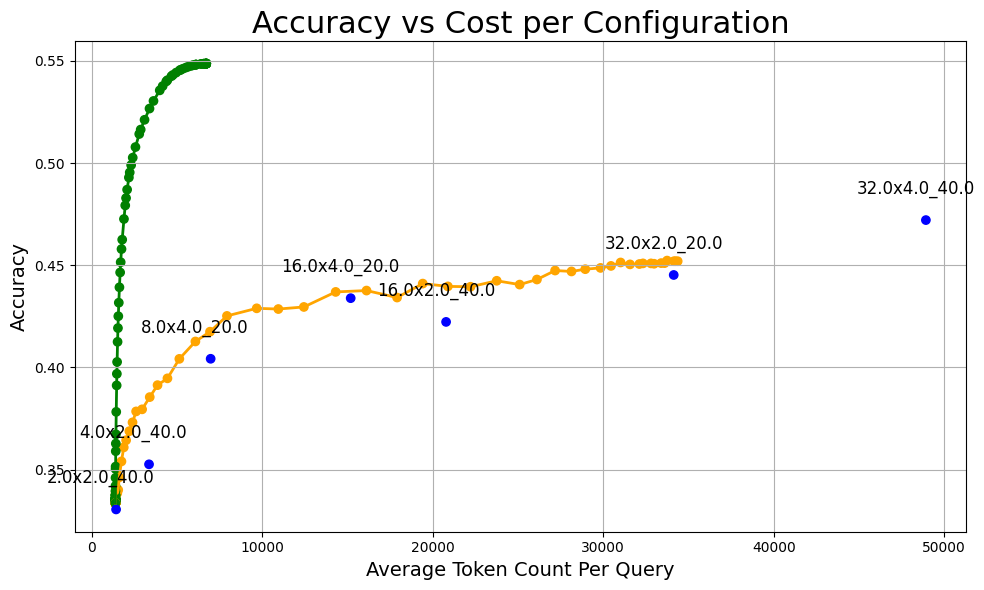

In [140]:
import matplotlib.pyplot as plt
import numpy as np

# Create color labels and text labels
colors = [
    'orange' if (row['N'], row['beam_width'], row['max_iteration'], row['method']) == (-1, -1, -1, "adaptive_router")
    else 'green' if row['method'] == "oracle"
    else 'blue'
    for _, row in query_optimal_tc.iterrows()
]

text_labels = [
    "qa" if (row['N'], row['beam_width'], row['max_iteration'], row['method']) == (-1, -1, -1, "adaptive_router")
    else None if row['method'] == "oracle"
    else f"{row['N']}x{row['beam_width']}_{row['max_iteration']}"
    for _, row in query_optimal_tc.iterrows()
]

plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_tc["token_count"], query_optimal_tc["sl"], color=colors)

# Connect orange dots with an orange line
orange_mask = [
    (row['N'], row['beam_width'], row['max_iteration'], row['method']) == (-1, -1, -1, "adaptive_router")
    for _, row in query_optimal_tc.iterrows()
]
if any(orange_mask):
    orange_x = np.array(query_optimal_tc["token_count"])[orange_mask]
    orange_y = np.array(query_optimal_tc["sl"])[orange_mask]
    # If more than one, sort by x for line
    if len(orange_x) > 1:
        idx = np.argsort(orange_x)
        plt.plot(orange_x[idx], orange_y[idx], color='orange', linewidth=2, zorder=1)

# Connect green dots with a green line
green_mask = [row['method'] == "oracle" for _, row in query_optimal_tc.iterrows()]
if any(green_mask):
    green_x = np.array(query_optimal_tc["token_count"])[green_mask]
    green_y = np.array(query_optimal_tc["sl"])[green_mask]
    if len(green_x) > 1:
        idx = np.argsort(green_x)
        plt.plot(green_x[idx], green_y[idx], color='green', linewidth=2, zorder=1)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_tc["token_count"][i], query_optimal_tc["sl"][i]),
                    textcoords="offset points", xytext=(-50, 19), ha='left', fontsize=12)

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=22)
plt.grid(True)
plt.tight_layout()

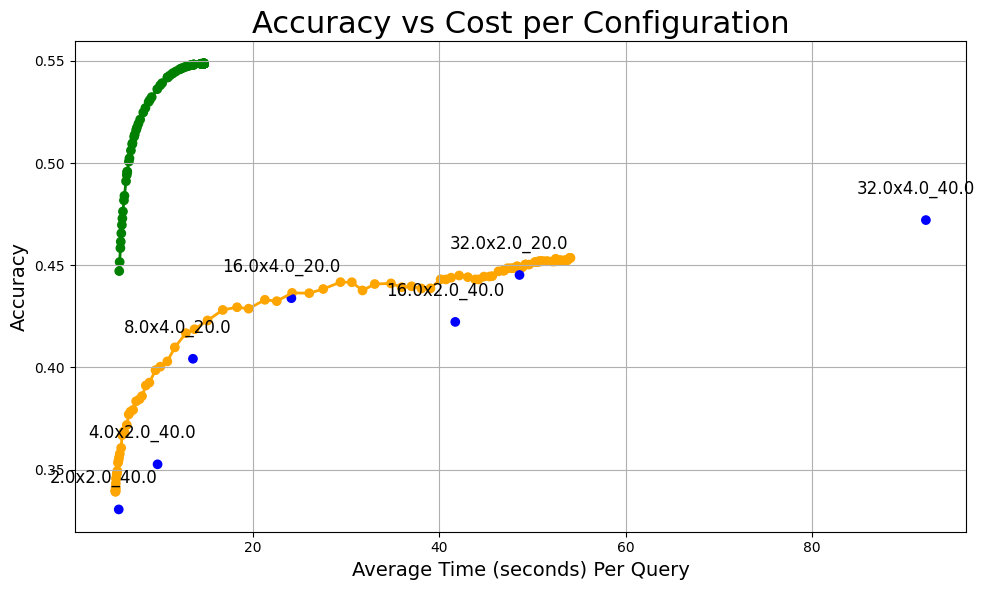

In [141]:
import matplotlib.pyplot as plt
import numpy as np

# Create color labels and text labels
colors = [
    'orange' if (row['N'], row['beam_width'], row['max_iteration'], row['method']) == (-1, -1, -1, "adaptive_router")
    else 'green' if row['method'] == "oracle"
    else 'blue'
    for _, row in query_optimal_late.iterrows()
]

text_labels = [
    "qa" if (row['N'], row['beam_width'], row['max_iteration'], row['method']) == (-1, -1, -1, "adaptive_router")
    else None if row['method'] == "oracle"
    else f"{row['N']}x{row['beam_width']}_{row['max_iteration']}"
    for _, row in query_optimal_late.iterrows()
]

plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_late["time"], query_optimal_late["sl"], color=colors)

# Connect orange dots
orange_mask = [
    (row['N'], row['beam_width'], row['max_iteration'], row['method']) == (-1, -1, -1, "adaptive_router")
    for _, row in query_optimal_late.iterrows()
]
if any(orange_mask):
    orange_x = np.array(query_optimal_late["time"])[orange_mask]
    orange_y = np.array(query_optimal_late["sl"])[orange_mask]
    # If more than one, sort by x for a nice line
    if len(orange_x) > 1:
        idx = np.argsort(orange_x)
        plt.plot(orange_x[idx], orange_y[idx], color='orange', linewidth=2, zorder=1)

# Connect green dots
green_mask = [
    row['method'] == "oracle"
    for _, row in query_optimal_late.iterrows()
]
if any(green_mask):
    green_x = np.array(query_optimal_late["time"])[green_mask]
    green_y = np.array(query_optimal_late["sl"])[green_mask]
    if len(green_x) > 1:
        idx = np.argsort(green_x)
        plt.plot(green_x[idx], green_y[idx], color='green', linewidth=2, zorder=1)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_late["time"][i], query_optimal_late["sl"][i]),
                    textcoords="offset points", xytext=(-50, 19), ha='left', fontsize=12)

plt.xlabel("Average Time (seconds) Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=22)
plt.grid(True)
plt.tight_layout()

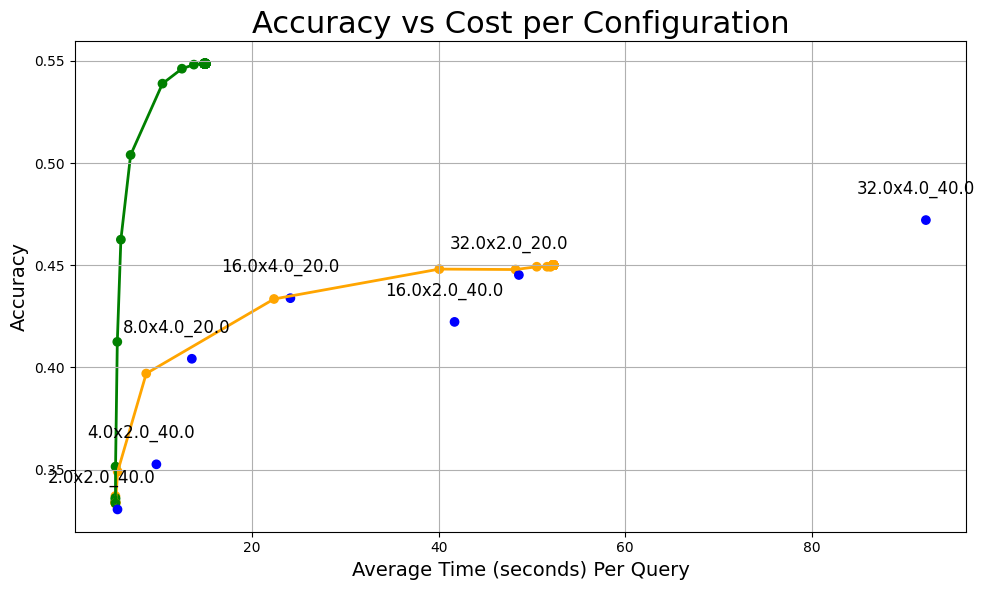

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create color labels and text labels
colors = [
    'orange' if (row['N'], row['beam_width'], row['max_iteration'], row['method']) == (-1, -1, -1, "adaptive_router")
    else 'green' if row['method'] == "oracle"
    else 'blue'
    for _, row in query_optimal_tc.iterrows()
]

text_labels = [
    "qa" if (row['N'], row['beam_width'], row['max_iteration'], row['method']) == (-1, -1, -1, "adaptive_router")
    else None if row['method'] == "oracle"
    else f"{row['N']}x{row['beam_width']}_{row['max_iteration']}"
    for _, row in query_optimal_tc.iterrows()
]

plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_tc["time"], query_optimal_tc["sl"], color=colors)

# Connect orange dots
orange_mask = [
    (row['N'], row['beam_width'], row['max_iteration'], row['method']) == (-1, -1, -1, "adaptive_router")
    for _, row in query_optimal_tc.iterrows()
]
if any(orange_mask):
    orange_x = np.array(query_optimal_tc["time"])[orange_mask]
    orange_y = np.array(query_optimal_tc["sl"])[orange_mask]
    # If more than one, sort by x for a nice line
    if len(orange_x) > 1:
        idx = np.argsort(orange_x)
        plt.plot(orange_x[idx], orange_y[idx], color='orange', linewidth=2, zorder=1)

# Connect green dots
green_mask = [
    row['method'] == "oracle"
    for _, row in query_optimal_tc.iterrows()
]
if any(green_mask):
    green_x = np.array(query_optimal_tc["time"])[green_mask]
    green_y = np.array(query_optimal_tc["sl"])[green_mask]
    if len(green_x) > 1:
        idx = np.argsort(green_x)
        plt.plot(green_x[idx], green_y[idx], color='green', linewidth=2, zorder=1)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_tc["time"][i], query_optimal_tc["sl"][i]),
                    textcoords="offset points", xytext=(-50, 19), ha='left', fontsize=12)

plt.xlabel("Average Time (seconds) Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=22)
plt.grid(True)
plt.tight_layout()

To Try Out Next:

- join with other methods.

- run larger beam sizes.

- calibrate model!

- indicators rather than accuracy.

- use pred probabilities as predictions.

#### Beam Times for Small vs. Large N Beam.

In [19]:
import re
import numpy as np

def extract_average_beam_search_time(log_file_path):
    """
    Extract all "Total beam search time:" values from a log file and calculate the average.
    
    Args:
        log_file_path (str): Path to the log file
        
    Returns:
        dict: Dictionary containing:
            - 'times': List of all beam search times in seconds
            - 'average': Average beam search time in seconds
            - 'count': Number of beam search operations
            - 'min': Minimum beam search time
            - 'max': Maximum beam search time
            - 'std': Standard deviation of beam search times
    """
    # Pattern to match "Total beam search time: X.XX seconds."
    pattern = r'Total beam search time: ([\d.]+) seconds\.'
    
    times = []
    
    try:
        with open(log_file_path, 'r') as file:
            for line in file:
                match = re.search(pattern, line)
                if match:
                    time_value = float(match.group(1))
                    times.append(time_value)
    except FileNotFoundError:
        print(f"Error: File '{log_file_path}' not found.")
        return None
    except Exception as e:
        print(f"Error reading file: {e}")
        return None
    
    if not times:
        print("No beam search times found in the log file.")
        return None
    
    # Calculate statistics
    times_array = np.array(times)
    result = {
        'times': times,
        'average': np.mean(times_array),
        'count': len(times),
        'min': np.min(times_array),
        'max': np.max(times_array),
        'std': np.std(times_array)
    }
    
    return result


In [20]:
# Test the function
result = extract_average_beam_search_time('/dccstor/gma2/jhjenny9/search-and-learn/large-beam-2.out')

print(f"Beam Time for N=128")
print(f"Found {result['count']} beam search operations")
print(f"Average time: {result['average']:.2f} seconds")
print(f"Min time: {result['min']:.2f} seconds")
print(f"Max time: {result['max']:.2f} seconds")
print(f"Standard deviation: {result['std']:.2f} seconds")
print(f"\nAll times: {result['times']}")

Beam Time for N=128
Found 10 beam search operations
Average time: 388.20 seconds
Min time: 133.41 seconds
Max time: 616.34 seconds
Standard deviation: 123.20 seconds

All times: [297.57, 403.46, 403.98, 415.98, 133.41, 616.34, 359.12, 514.49, 431.28, 306.37]


In [21]:
# Test the function
result = extract_average_beam_search_time('/dccstor/gma2/jhjenny9/search-and-learn/large-beam.out')

print(f"Beam Time for N=32")
print(f"Found {result['count']} beam search operations")
print(f"Average time: {result['average']:.2f} seconds")
print(f"Min time: {result['min']:.2f} seconds")
print(f"Max time: {result['max']:.2f} seconds")
print(f"Standard deviation: {result['std']:.2f} seconds")
print(f"\nAll times: {result['times']}")

Beam Time for N=32
Found 100 beam search operations
Average time: 81.80 seconds
Min time: 10.66 seconds
Max time: 264.00 seconds
Standard deviation: 57.81 seconds

All times: [24.76, 19.27, 99.12, 95.19, 26.03, 78.23, 13.39, 31.76, 134.76, 11.11, 56.41, 121.37, 109.11, 18.25, 264.0, 23.91, 62.78, 65.45, 64.4, 48.95, 118.92, 120.7, 24.39, 70.16, 160.42, 25.36, 167.64, 103.07, 88.3, 13.57, 27.39, 85.95, 21.11, 37.36, 41.51, 78.14, 77.44, 123.13, 122.26, 24.13, 20.46, 99.25, 21.17, 75.69, 24.67, 15.8, 19.05, 43.24, 115.7, 135.53, 67.32, 125.27, 73.35, 81.99, 224.16, 52.6, 103.65, 67.62, 130.81, 175.54, 21.22, 120.32, 176.65, 16.03, 105.63, 90.8, 23.85, 31.28, 36.32, 26.99, 91.97, 111.23, 217.35, 101.09, 35.78, 12.05, 51.53, 110.73, 189.84, 19.03, 11.21, 144.93, 16.41, 42.49, 98.03, 197.02, 102.67, 90.83, 139.4, 173.64, 77.79, 120.7, 82.18, 32.01, 40.53, 134.08, 104.03, 177.38, 222.48, 10.66]
